<a href="https://colab.research.google.com/github/Anna172/Python/blob/master/Wavelet_Analysis%D0%B4%D0%B73.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wavelet** **Analysis**
Home task №3

# Анна Трушникова ББИ172
Данные все те же: https://www.federalreserve.gov/datadownload/Download.aspx?rel=H10&series=a3220d269bb3c9c5e2fffa49160c8cdf&filetype=csv&label=include&layout=seriescolumn&lastObs=10

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks', palette='Set2')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


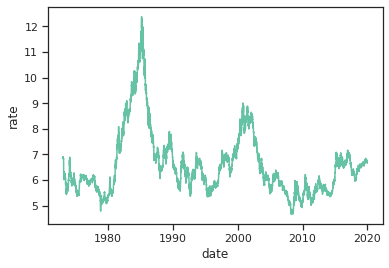

In [6]:
DKKUsd_ts = pd.read_csv("FRB_H10.csv", parse_dates=['date']) 
DKKUsd_ts = DKKUsd_ts[DKKUsd_ts['rate'] != 'ND']
DKKUsd_ts['rate'] = DKKUsd_ts.rate.values.astype('float')
sns.lineplot(x='date', y='rate', data=DKKUsd_ts)

## PyCWT

https://pycwt.readthedocs.io/en/latest/

In [7]:
# pyCWT can be also installed via conda install
!pip install pycwt

In [8]:
import pycwt as wavelet
from pycwt.helpers import find

In [9]:
label = 'Rate'
title = 'DKK/USD Exchange Rate'
dat = DKKUsd_ts.rate.values.astype('float')
N = dat.size
t = DKKUsd_ts.date.values.astype('float') / (31556926*1e9)+1970 # Float value of year

# Try to detrend the time series...
# p = np.polyfit(t - t[0], dat, 1)
# dat_detrend = dat - np.polyval(p, t - t[0])

# ... or just substract the mean if there is no trend
dat_detrend = dat - np.mean(dat)
std = dat_detrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_detrend / std  # Normalized time series

# dt = (t[-1] - t[0]) / N 
dt = 1 / 261 # time step

In [10]:
mother = wavelet.Morlet()
s0 = 2*dt 
dj = 1 / 5  # five sub-octaves per octaves
J = 9 / dj  # Seven powers of two with dj sub-octaves
# alpha, _, _ = wavelet.ar1(dat_norm)  # Lag-1 autocorrelation for red noise

In [11]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      wavelet=mother)

In [12]:
power = (np.abs(wave)) ** 2
power /= scales[:, None]
periods = 1 / freqs

# clip COI boundary values so they won't extend the plot limits
coi = np.clip(coi, np.min(periods), np.max(periods))

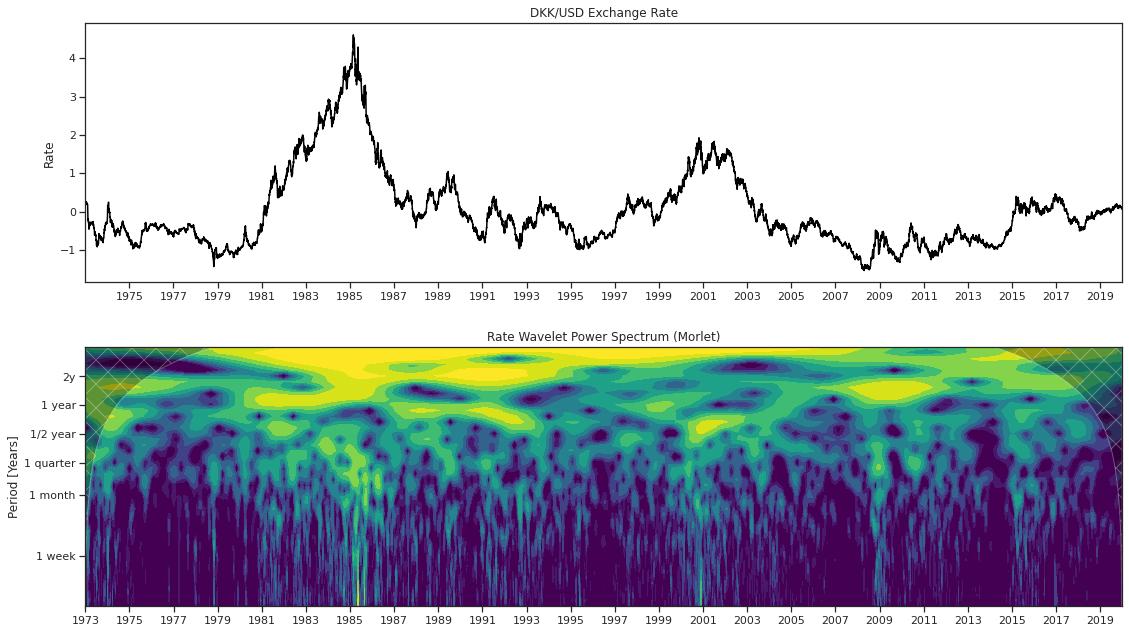

In [13]:
# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(16, 9))
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = plt.axes([0.05, 0.55, 0.9, 0.4])
ax.plot(t, dat_norm, 'k', linewidth=1.5)
ax.set_title('{}'.format(title))
ax.set_ylabel(r'{}'.format(label))

# Second sub-plot, the normalized wavelet power spectrum. Note that period
# scale is logarithmic.
bx = plt.axes([0.05, 0.05, 0.9, 0.4], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(periods), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)

# COI (Cone of Influence)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(periods[-1:]),
                           np.log2(periods[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')

bx.set_title('{} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period [Years]')
Yticks = [dt*7, dt*30, 0.25, 0.5, 1, 2]
YticksLabels = ['1 week', '1 month', '1 quarter', '1/2 year', '1 year', '2y']
bx.set_xticks(range(1973, 2021, 2))
bx.set_xticklabels(range(1973, 2021, 2))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(YticksLabels)
#

plt.show()

**Вывод**: самые мощные колебания имеют период более двух лет. С 1975-1977 область колебаний с низким периодом(в неделю) имеет темный цвет, что говорит о незначительном изменении краткосросного курса. С 1985 по 1987 коэффициент мощности для области колебаний с низким периодом, судя по цвету, значительно больше, что говорит о том, что колебания в течение этих лет были существеннее, чем в 1975-1977. Это видно и на обычном графике курса кроны.
